# Persistence analysis

En este proyecto se utilizarán herramientas de visualización/exploración de datos: encaje de Takens, complejos simpliciales, homología persistente, diagramas persistentes, códigos de barras, diagramas de densidad e imágenes de persistencia para estudiar una serie de tiempo.

Realizaremos un análisis exploratorio del conjunto de datos proporcionado. El objetivo es comprender y poder explicar los patrones que observa en el conjunto de datos.
Entrega un reporte 

### Import libraries

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
import matplotlib
import seaborn as sb
import matplotlib.cm as cm
import matplotlib.patches as patches
plt.rcParams.update(plt.rcParamsDefault)
from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_point_cloud
import plotly.graph_objects as go
from nolitsa import dimension, delay
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform,pdist
import math

sb.set(style="whitegrid")

### Data

In [2]:
headers=['Year','JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
datos= pd.read_fwf('nino34.long.anom.data.txt', names=headers)
datos = datos.drop(datos.index[-1])
datos

,Year,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1870,-1.00,-1.20,-0.83,-0.81,-1.27,-1.08,-1.04,-0.88,-0.53,-0.92,-0.79,-0.79
1,1871,-0.25,-0.58,-0.43,-0.50,-0.70,-0.53,-0.60,-0.33,-0.24,-0.33,-0.31,-0.58
2,1872,-0.72,-0.62,-0.50,-0.77,-0.62,-0.52,-0.32,-0.85,-1.02,-0.94,-0.79,-0.88
3,1873,-0.78,-1.01,-1.31,-0.67,-0.53,-0.48,-0.58,-0.39,-0.34,-0.78,-0.77,-0.70
4,1874,-0.93,-1.06,-1.40,-0.94,-0.86,-0.72,-1.00,-1.05,-1.13,-1.25,-1.33,-1.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,2014,-0.42,-0.45,-0.07,0.28,0.45,0.48,0.13,0.14,0.37,0.48,0.89,0.77
145,2015,0.59,0.57,0.48,0.90,1.04,1.28,1.56,1.87,2.01,2.21,2.57,2.56
146,2016,2.56,2.11,1.60,1.05,0.45,0.06,-0.25,-0.48,-0.46,-0.75,-0.63,-0.51
147,2017,-0.34,-0.01,-0.09,0.22,0.30,0.22,0.22,-0.18,-0.56,-0.52,-0.84,-0.85


### Análisis Exploratorio

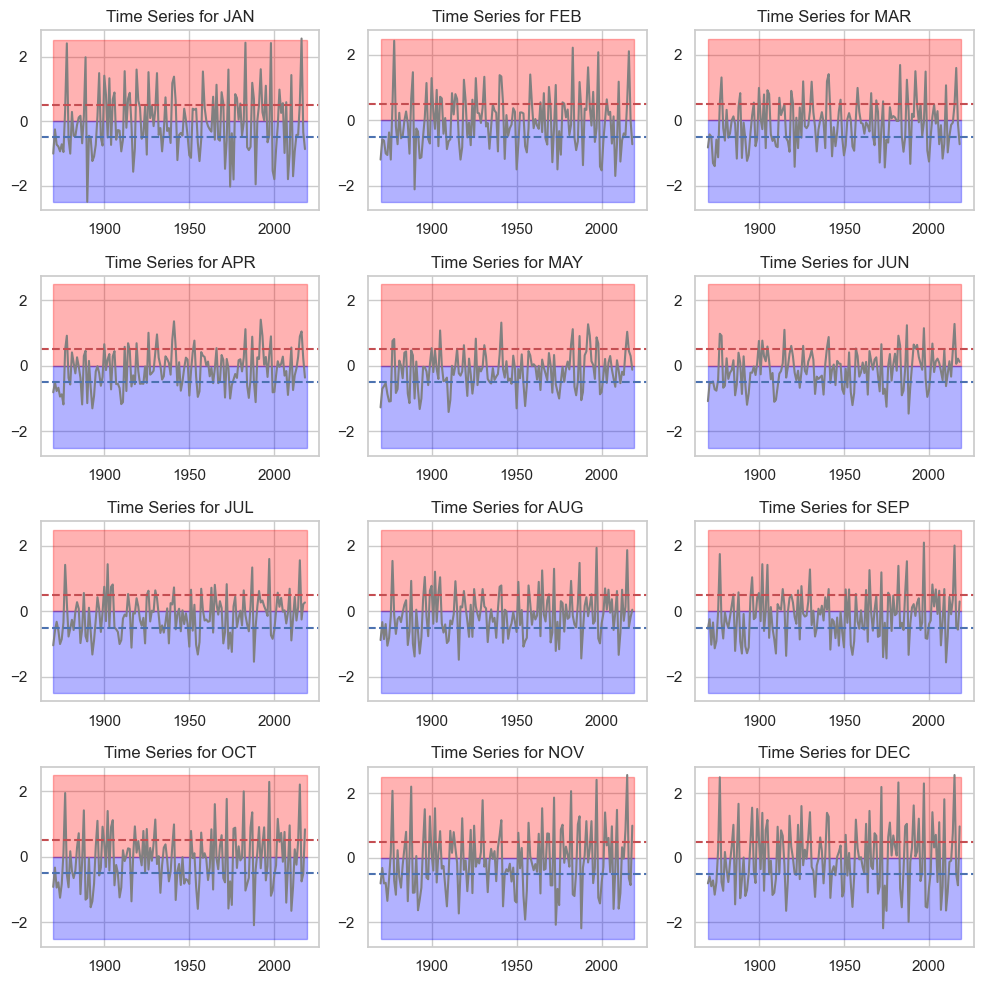

In [3]:


# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows= 4, ncols=3, figsize=(10, 10))
axes = axes.flatten()  # Flatten the array to make indexing easier in a loop
x,y = (datos["Year"],datos.iloc[:,1:])

y_boy =  y[(y >=0.5).any(axis=1)]
y_girl =  y[(y <=0.5).any(axis=1)]




#colors
cmap =  cm.get_cmap('viridis',12) 
# Plot each column
for i,column in enumerate(y.columns):
    color = cmap(i)
    #Agregar colores de fondo
    axes[i].add_patch(patches.Rectangle((1870,0),y.shape[0],2.5,color='red',alpha=0.3)) #color rojo para el Niño
    axes[i].add_patch(patches.Rectangle((1870,0),y.shape[0],-2.5,color='blue',alpha=0.3)) #color rojo para la Nina
    axes[i].plot(x,y[column],marker="",linestyle="-",color="gray")
    axes[i].set_title(f'Time Series for {column}')
    axes[i].axhline(y=0.5, color='r', linestyle='--')
    axes[i].axhline(y=-0.5, color='b', linestyle='--')
    axes[i].grid(True)



# Adjust layout
plt.tight_layout()
plt.show()

### Encaje de Takens

Esta técnica es utilizada en funciones de serie de tiempo para **comprobar si son periodicas con el tiempo**. Mas formalemente, si tenemos una serie de tiempo $f(t)$ la cual tenemos discretizada (un tamaño k de pesa por cada zancada).

$$f(t) = f(t_1),f(t_1 + k),f(t_1 + 2k),...,f(t_1 + nk)$$

Donde:

$$k = t_{i+1} - t_i$$

Dado lo anterior, podemos encajar nuestros datos en un espacio de dimension d. Para esto, consideramos para cada i un delay de tiempo $\tau$:

$$F(t_i) = (f(t_i),f(t_i + \tau),...,f(t_i +  (d - 1)\tau))$$

* $f(t_i)$ se llama **inicio de la ventana**
* $f(t_i + (d-1)\tau)$ se llama **final de la ventana**

#### Teorema de Florin Takens

Si se escogen bien los parámetros $(\tau,d)$ para una señal discretizada $f(t)$ con valores en los reales $(ℝ,t)$ entonces la función:

$$Tf_{τ,d}:ℝ \to ℝ$$

Esta misma está definida por $Tf_{τ,d}(t) = (f(t_i),f(t_i + \tau),...,f(t_i +  (d - 1)\tau))$, el cual es un  **difeomorfismo**


La promesa del teorema del encaje de Takens es que si los datos son periódicos entonces la imagen del encaje forma una elipse, esto es:

$$β_0 =  β_1 = 1$$
$$β_n = 0,∀n > 1$$

Es decir, que la transformacion que se le aplique a nuestra serie de tiempo, tiene que retornar una matriz en el espacio euclediano $ℝ^2$ que sean las coordenadas que formen a un **cículo (elipse)** 

Sin embargo, tenemos que obtener los valores óptimos para $\tau$ y $d$,¿cuáles serían?

In [16]:
parametros_optimos = pd.DataFrame(columns = ["column","tau","d"])
parametros_optimos

,column,tau,d


In [37]:
#La parte real de la raiz de la cantidad de datos (probamos otros datos)
max_periodic_dimension = 11
max_periodic_time_delay = 11
stride = 1
parametros_optimos = pd.DataFrame(columns = ["column","tau","d"])

for i,column in enumerate(y.columns):
    tau,d= takens_embedding_optimal_parameters(y[column], max_periodic_dimension, max_periodic_time_delay, stride)
    #print('Optimal time delay: ', tau,'\nOptimal dimension: ', d)
    #print("<----------------------->")
    parametros_optimos.loc[i] = [column,tau,d]
    
parametros_optimos

,column,tau,d
0,JAN,2,4
1,FEB,2,5
2,MAR,11,4
3,APR,10,5
4,MAY,9,4
5,JUN,3,4
6,JUL,4,5
7,AUG,1,4
8,SEP,6,4
9,OCT,4,4


El algoritmo de giotto-tda nos da como resultado que el parámetro óptimo para el time_delay es 29 y la dimensión óptima es 18, cuando el stride es 1.

Si modificamos el stride, estos parámetros cambiarán.

El delay encontrado es  2
La dimension encontrada es  4
Shape of embedded time series: (143, 4)


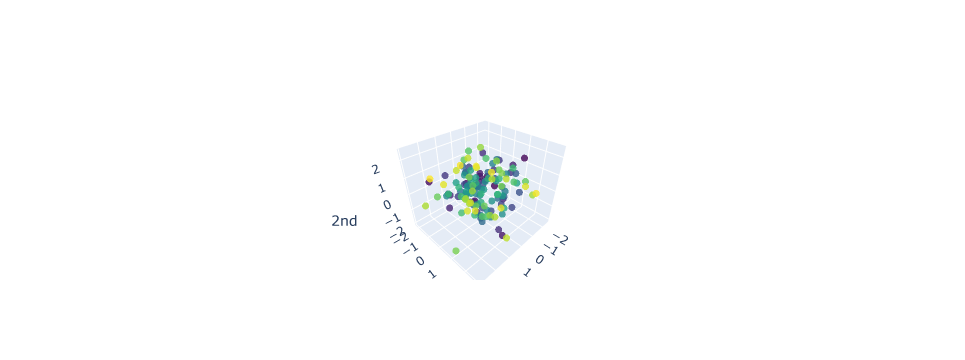

In [45]:
#mes de enero
embedder_periodic = SingleTakensEmbedding(parameters_type="search",time_delay=max_periodic_time_delay,
    dimension=max_periodic_dimension)
y_periodic_embedded = embedder_periodic.fit_transform(y["JAN"])
print("El delay encontrado es ", embedder_periodic.time_delay_)
print("La dimension encontrada es ", embedder_periodic.dimension_)


print(f"Shape of embedded time series: {y_periodic_embedded.shape}")

pca = PCA(n_components=3)
y_periodic_embedded_pca = pca.fit_transform(y_periodic_embedded)
plot_point_cloud(y_periodic_embedded_pca)

In [47]:
plt.figure(figsize=(9,4))
plt.xlabel('Time delay (tau)')
plt.ylabel('Mutual Information')
plt.plot(delay.dmi(y["JAN"], maxtau=30))

### Complejos simpliciales

In [4]:
cormat = datos.corr()
cormat=cormat.drop(['Year'])
cormat=cormat.drop(['Year'],axis=1)
cormat

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
JAN,1.000000,0.956577,0.894807,0.764633,0.574411,0.398006,0.174443,0.084676,0.035391,-0.014049,-0.031201,-0.014473
FEB,0.956577,1.000000,0.944026,0.828588,0.658811,0.461418,0.263883,0.175525,0.113844,0.061429,0.052641,0.060080
MAR,0.894807,0.944026,1.000000,0.878627,0.731230,0.532904,0.335967,0.249785,0.189424,0.127011,0.130807,0.130586
APR,0.764633,0.828588,0.878627,1.000000,0.867935,0.684655,0.515972,0.439223,0.374703,0.300043,0.282053,0.267816
MAY,0.574411,0.658811,0.731230,0.867935,1.000000,0.846134,0.708509,0.628158,0.582422,0.516090,0.499839,0.484755
JUN,0.398006,0.461418,0.532904,0.684655,0.846134,1.000000,0.867899,0.799871,0.740811,0.722307,0.696742,0.687840
JUL,0.174443,0.263883,0.335967,0.515972,0.708509,0.867899,1.000000,0.928383,0.877489,0.847765,0.824890,0.809726
AUG,0.084676,0.175525,0.249785,0.439223,0.628158,0.799871,0.928383,1.000000,0.931102,0.910146,0.876710,0.868339
SEP,0.035391,0.113844,0.189424,0.374703,0.582422,0.740811,0.877489,0.931102,1.000000,0.940134,0.915314,0.887477
OCT,-0.014049,0.061429,0.127011,0.300043,0.516090,0.722307,0.847765,0.910146,0.940134,1.000000,0.954730,0.938329


In [5]:
#dist = pd.DataFrame(squareform(pdist(cormat), "euclidean"), columns=data.index.values, index=data.index.values)
#dist

### Homología Persistente

### Digramas de persistencia

### Codigos de barras

### Diagramas de densidad